In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
path2data = '../data/avg_weather_data'
def realpath(fname):
    return os.path.join(path2data,fname)

### Merging weather and crop data for each location at each month-year time

To get the full dataset to train the model here I merge the target variable from the urban farm data for each vegetable to the weather data, matching at every location and month-year.

In [2]:
crop = pd.read_csv(realpath('crop_clean_location.csv'))
avgsub = pd.read_csv(realpath('avgsub4.csv'), low_memory=False)

Crop Categories

In [3]:
vegetable = ['amaranth', 'arugula', 'greens','asparagus', 'peppers','beans', 'basella alba','beetroot', 'peas',
       'bok choy', 'gourd','broccoli', 'fennel','brussels sprouts', 'squash', 'cabbage', 'mesclun',
       'carrots', 'celery', 'chard', 'tomato', 'collards', 'corn', 'cress', 'cucumbers','kale',
       'edamame', 'eggplant','escarole','garlic', 'lettuce','habeneros', 'radish', 'jalapenos',
       'kohlrabi', 'leeks','okra', 'onion','potatoes', 'pumpkin', 'spinach', 'sweet potato',
       'taro', 'tomatillos', 'turnip','zucchini', 'artichoke', 'barley', 'callaloo', 'chili',
       'collalo', 'cotton','grains',  'koji', 'komatsuna', 'millet', 'quinoa','romanesco', 'tatsoi'
        'winter purslane', 'yam','yukina savoy', 'endive','parsnip', 'tatsoi',  'winter purslane']

In [4]:
fruit = ['almond tree', 'apples', 'apricots', 'avocado', 'banana', 'blackberries', 'muleberry'
       'blueberry', 'boysenberries','cantaloupe','cherries', 'currants', 'elderberry','figs',
        'ginko sapling', 'goji berries','paw paw', 'gooseberry', 'grapes', 'ground cherry',  'hazelnut',
        'huckleberry', 'kiwi', 'lemon tree', 'lychee', 'melon','mulberry', 'nectarines',
       'northern dewberries', 'papaya','peaches', 'peanuts', 'pear', 'persimmon','plums', 'pluot', 'pomegranate', 'raspberry',
       'rhubarb', 'serviceberry','strawberry', 'sugar cane', 'walnut tree', 'wineberries', 'wonderberry', 'moringa']

In [5]:
herbs=[ 'anise',  'basil', 'chives', 'cilantro', 'dill', 'epazote', 'fenugreek', 'ginger',
     'lemon balm', 'lemongrass', 'lovage', 'marjoram', 'mint', 'mizuna', 'curry',
    'motherwort', 'mustard', 'oregano', 'papalo', 'parsley', 'rosemary',
        'sage', 'scallions', 'sesame', 'shiso', 'sorrel', 'sour leaf', 'spilanthes', 'stevia', 'tarragon', 'thyme', 'watercress', 'wheatgrass']

In [6]:
flowers=['alache', 'alfalfa', 'allium', 'aloe', 'angelica', 'anise hyssop',
       'asta', 'autumn star', 'bachelors button', 'black-eyed susans',
       'borage', 'burdock', 'calendula', 'cardoon', 'catnip', 'chamomile',
       'comfrey', 'cosmo', 'dahlia', 'daisies', 'dandelion',
       'dusty miller', 'echninecea', 'evening primrose',
     'golden rod', 'guardinia',  'hibiscus','ochra',
       'honey dew', 'lavender', 'lemon verbena', 'marigolds', 'milkweed',
       'minutina', 'monarda fistulosa', 'mugwort',
       'nasturtium', 'nettles', 'purslane', 'rue',
       'snapdragon', 'sorghum', 'tansy', 'tulips',
       'valerian', 'varbana', 'vinca', 'yarrow', 'zinnia']

Getting zip codes to matc over

In [7]:
avgsub['zip'] = avgsub['zip'].astype(str)
avgsub['garden zip code'] = avgsub['zip']
avgsub = avgsub.set_index('garden zip code')

In [8]:
weazip = avgsub['zip'].unique()

Splitting urban farm data by crop

In [9]:
def crop_split(crop_name):
    cropsplit = crop[crop['crop']==crop_name]
    cropsplit = cropsplit[['crop','zip', 'month_year', 'month', 'year', 'quant_per_tot']].drop_duplicates()
    return cropsplit

In [10]:
def crop_group(data, crop_name):
    idzip = data.zip.unique()
    idtime = data.month_year.unique()
    cropgroup = pd.DataFrame(columns=['crop','zip', 'month_year', 'month', 'year', 'quantTot'] )
    for z in idzip:
        cropz = data.loc[z]
        cropzflat = cropz.to_numpy().flatten()
     
        if cropzflat.shape[0]>6:
            idtime = cropz.month_year.unique()
            for (i,t) in enumerate(idtime):
                group = cropz[cropz['month_year']==t]
               
                qsum = np.sum(group['quant_per_tot'].to_numpy()).reshape(1)
           
                info = group[['crop','zip', 'month_year', 'month', 'year']].drop_duplicates().to_numpy().reshape(5)
                sumrow = np.concatenate((info, qsum)).reshape(1,6)
        
                if i ==0:
                    totyear = sumrow
            
                if i>0:
         
                    totyear = np.concatenate((totyear, sumrow), axis=0)
            
       
                totdf = pd.DataFrame(totyear, columns = ['crop','zip', 'month_year', 'month', 'year', 'quantTot'])
   #         print(totdf)
                cropgroup = cropgroup.append(totdf, ignore_index = True)
        else:
           
            t = cropz.month_year
           
            qsum = cropz['quant_per_tot'].reshape(1)
           
        
            info = group[['crop','zip', 'month_year', 'month', 'year']].drop_duplicates().to_numpy().reshape(5)
            sumrow = np.concatenate((info, qsum)).reshape(1,6)
            totyear = sumrow
            totdf = pd.DataFrame(totyear, columns = ['crop','zip', 'month_year', 'month', 'year', 'quantTot'])
   #      
            cropgroup = cropgroup.append(totdf, ignore_index = True)
  #  print(cropgroup)
    cropgroup = cropgroup.drop_duplicates()
    return cropgroup
            

Merge and save data for each crop

In [11]:
def merge_cropwea(data, name):
    merged_weacrop = data.merge(avgsub, how = 'inner', on=['month_year', 'zip']).drop_duplicates()
    merged_weacrop.to_csv(f'../data/merged_data/cropwea{name}.csv')
    return merged_weacrop

Dictionary of crop-weahter data files to easily load them later, split for each vegetable.

In [12]:
veg_dict = {}
for plant in vegetable:
    crop_data = crop_split(plant)
    merge_cropwea(crop_data, plant)
    veg_dict[plant] = (f'../data/merged_data/cropwea{plant}.csv')

In [25]:
fru_dict = {}
for plant in fruit:
    crop_data = crop_split(plant)
    merge_cropwea(crop_data, plant)
    fru_dict[plant] = (f'../data/merged_data/cropwea{plant}.csv')

In [26]:
her_dict = {}
for plant in herbs:
    crop_data = crop_split(plant)
    merge_cropwea(crop_data, plant)
    her_dict[plant] = (f'../data/merged_data/cropwea{plant}.csv')

In [27]:
flo_dict = {}
for plant in flowers:
    crop_data = crop_split(plant)
    merge_cropwea(crop_data, plant)
    flo_dict[plant] = (f'../data/merged_data/cropwea{plant}.csv')

In [13]:
with open("../data/merged_data/veg_dict.json", "w") as f:
    json.dump(veg_dict, f)

In [28]:
with open("../data/merged_data/fru_dict.json", "w") as f:
    json.dump(fru_dict, f)

In [29]:
with open("../data/merged_data/her_dict.json", "w") as f:
    json.dump(her_dict, f)

In [30]:
with open("../data/merged_data/flo_dict.json", "w") as f:
    json.dump(flo_dict, f)

### Looking at correlation matrix of features and targed variable

In [14]:
tomatosplit = crop_split('tomato')
peppersplit = crop_split('peppers')
collardssplit = crop_split('collards')

In [15]:
cropweapepper = peppersplit.merge(avgsub, how = 'inner', on=['month_year', 'zip']).drop_duplicates()

In [16]:
cropweacollards = collardssplit.merge(avgsub, how = 'inner', on=['month_year', 'zip']).drop_duplicates()

In [17]:
cropweatomato = tomatosplit.merge(avgsub, how = 'inner', on=['month_year', 'zip']).drop_duplicates()

In [18]:
cropweared = cropweatomato[['quant_per_tot', 'mintempC',
       'maxtempC', 'sunHour', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'windspeedKmph']] 

In [19]:
def cropweafeat(crop_name, data):
    df = data[data['crop']==crop_name]
    df =  df[['quant_per_tot', 'mintempC',
       'maxtempC', 'sunHour', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'windspeedKmph']] 
    return df

In [20]:
tomatofeat = cropweafeat('tomato', cropweatomato)

peppersfeat = cropweafeat('peppers', cropweapepper)
collardsfeat = cropweafeat('collards', cropweacollards)

In [21]:
def corr_crop(featdata, veg):
    corr_cropwea =featdata.corr(method="pearson")
    plt.rcParams['figure.figsize']=(15,15)
    plt.title(f'{veg} correlation with weather features')
    ax = sns.heatmap(corr_cropwea, xticklabels=True, yticklabels=True, annot=True,square=True,fmt='0.2f')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.savefig(f'{veg}corr.png')
    plt.show()

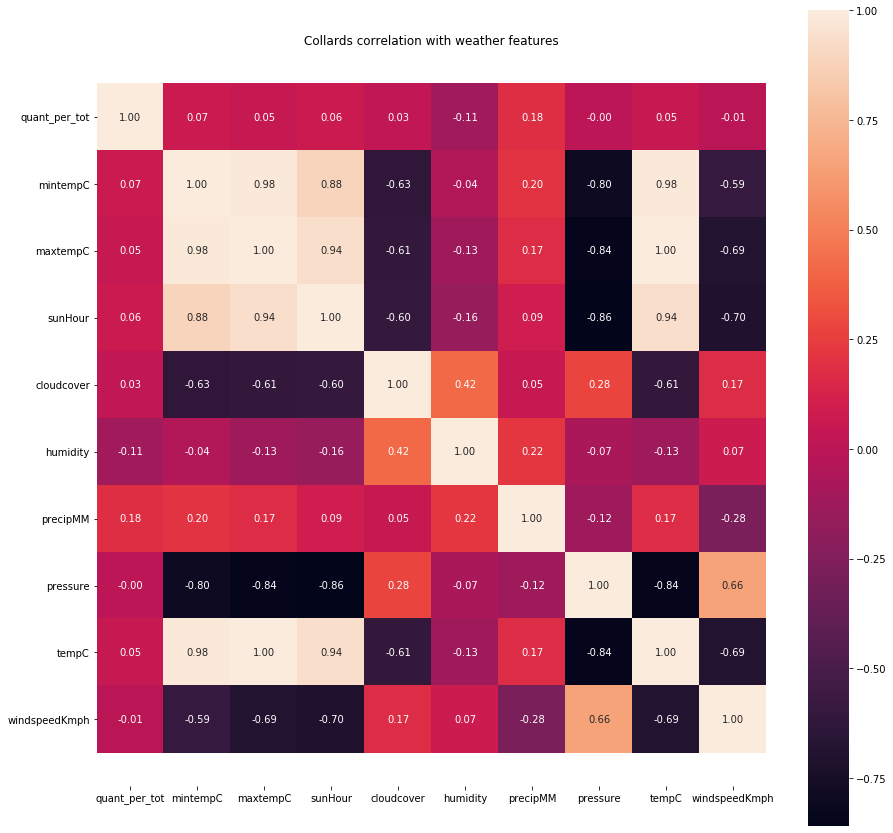

In [22]:
corr_crop(collardsfeat, 'Collards')

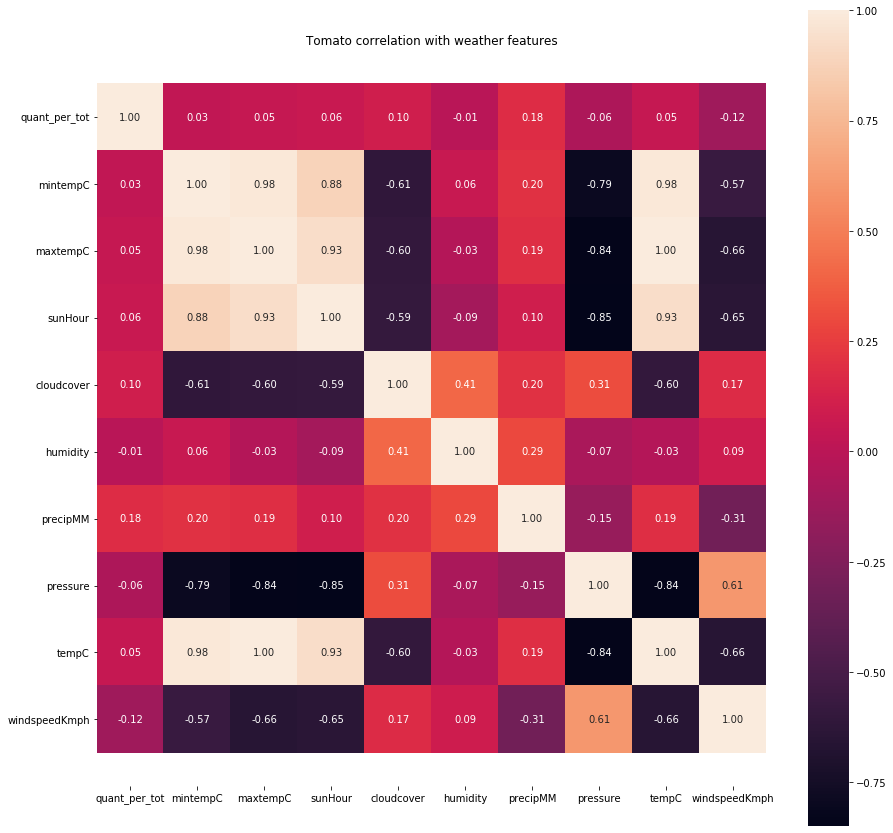

In [23]:
corr_crop(tomatofeat, 'Tomato')

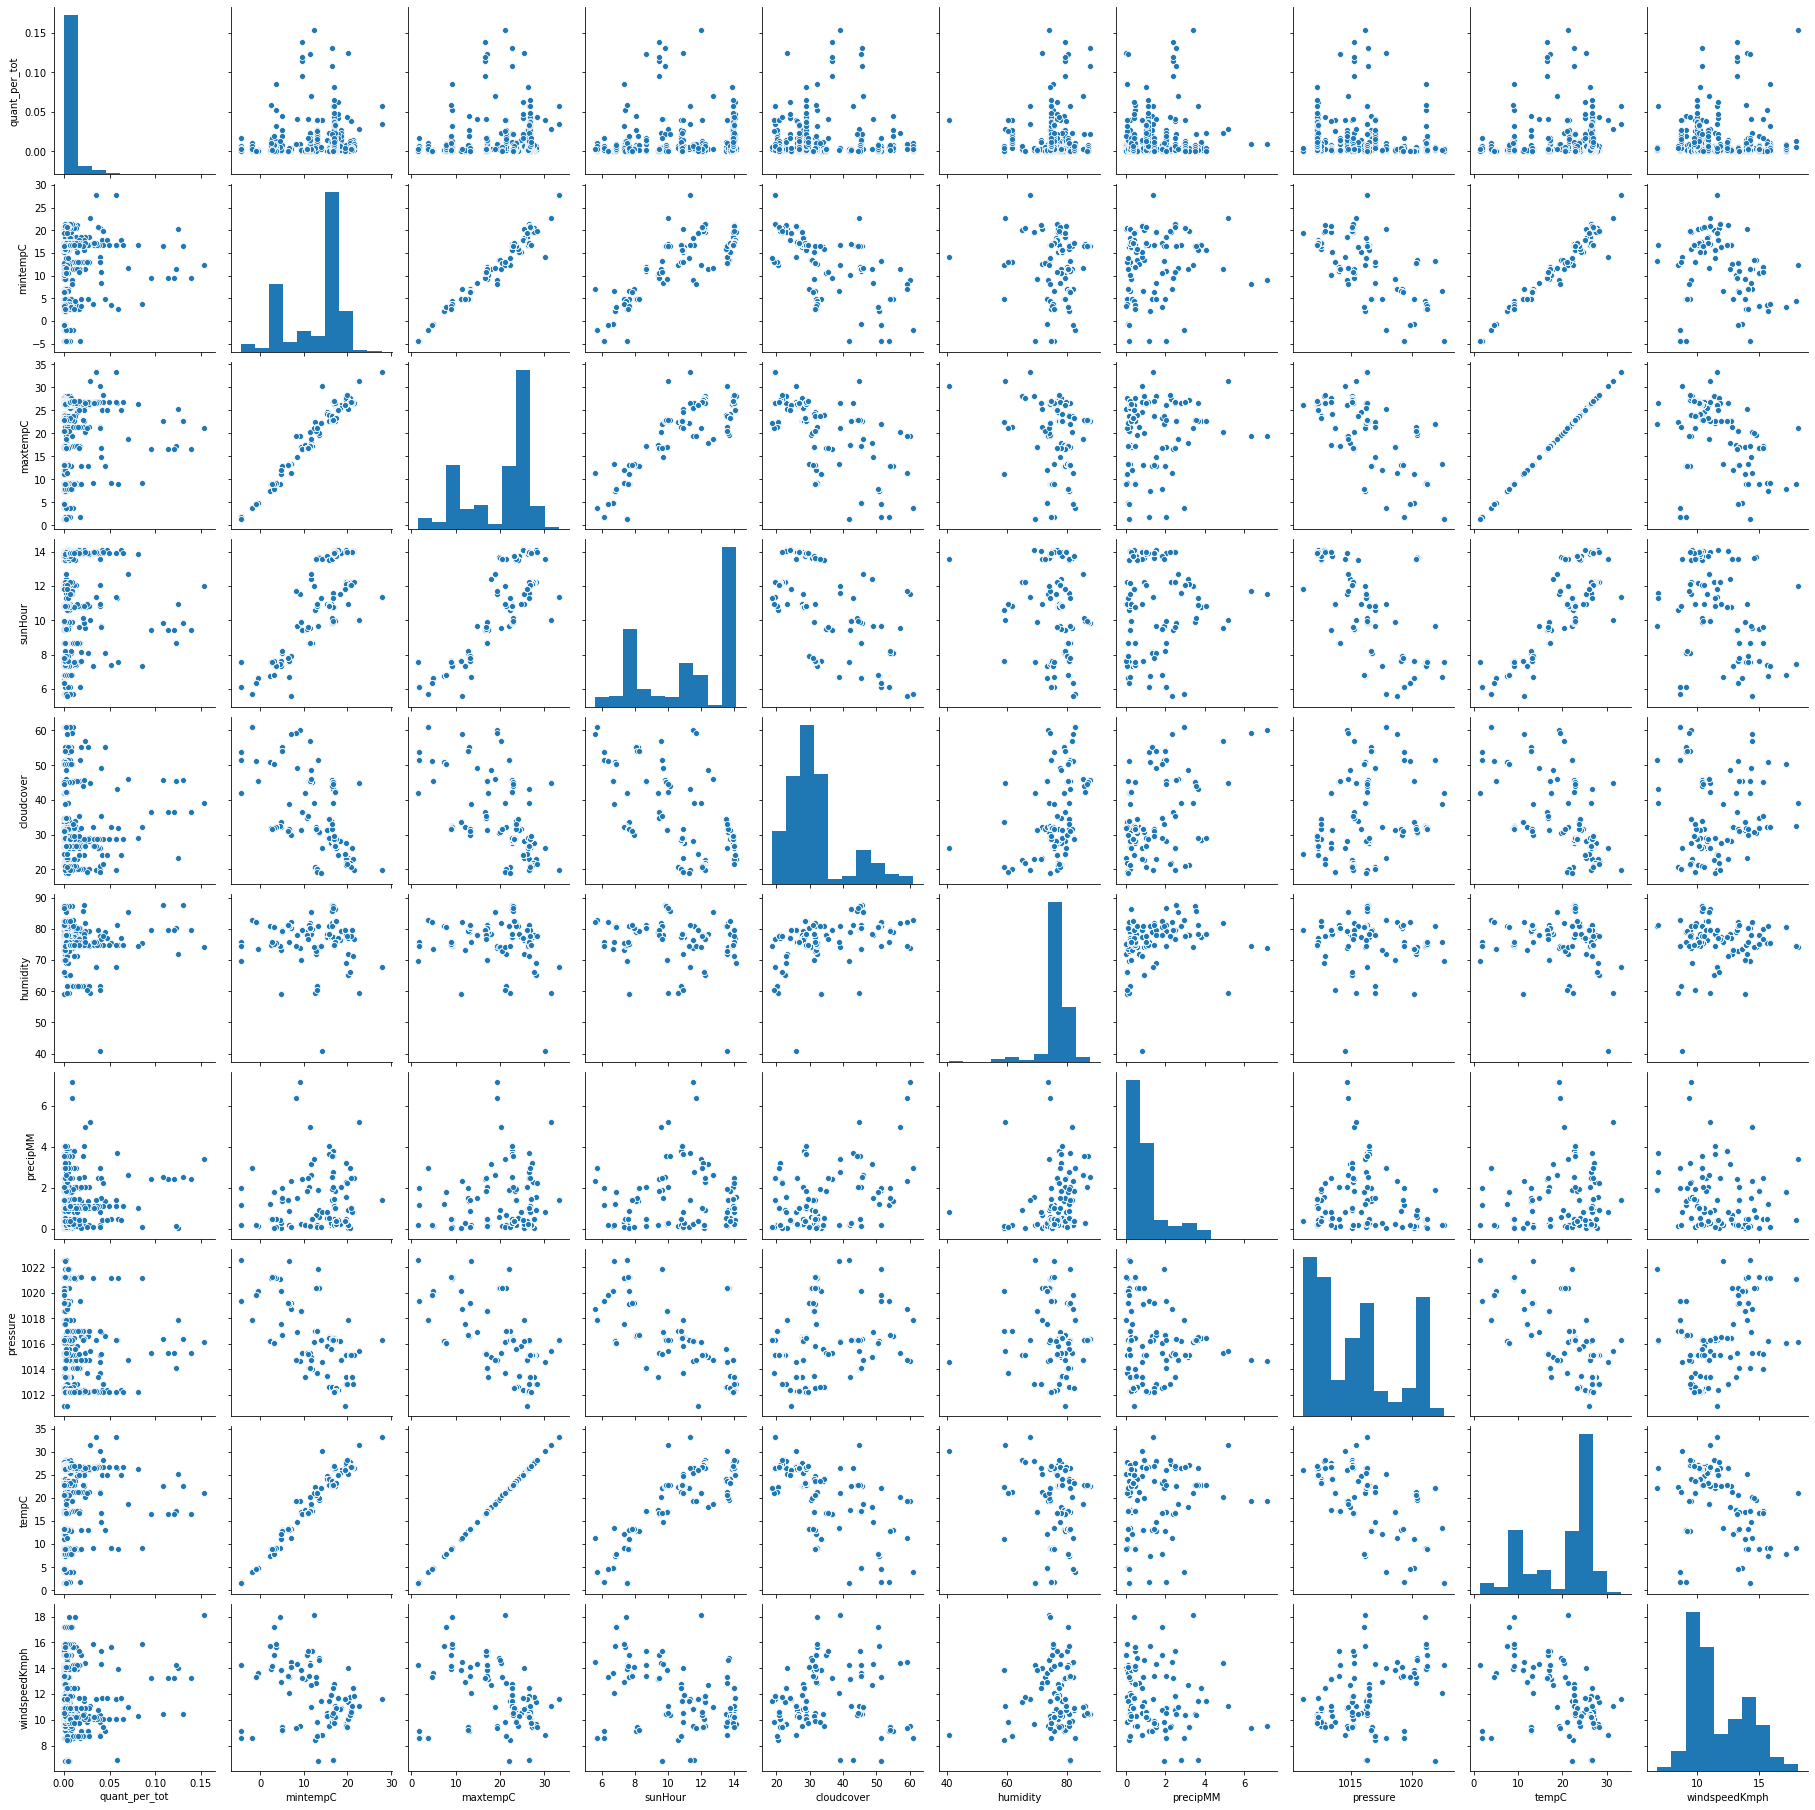

In [24]:
sns.pairplot(peppersfeat, kind='scatter')
plt.show()